# Benchmark Architectures: Resnet AlexNet VGG 

In [1]:
#data access from drive is slower 

# from google.colab import drive
# drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# !ls "/content/drive/My Drive/app/data-colab"

data_sperm


In [0]:
# import tensorflow as tf
# print(tf.__version__)

1.13.1


In [0]:
# !pip install -q tf-nightly-2.0-preview

     |████████████████████████████████| 88.1MB 220kB/s 
     |████████████████████████████████| 61kB 24.2MB/s 
     |████████████████████████████████| 3.1MB 30.0MB/s 
     |████████████████████████████████| 440kB 44.9MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [34]:
# from tensorflow import summary
# %load_ext tensorboard

#import files from local zip

from google.colab import files
uploaded = files.upload()

In [0]:
from __future__ import print_function, division

#debugging
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# import tensorflow as tf
# from torch.utils.tensorboard import SummaryWriter


plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.

# Data augmentation and normalization for training
# Just normalization for validation


data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(50, fill=0, padding_mode='constant'),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(20, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Writer will output to ./runs/ directory by default
#writer = SummaryWriter()

# base_dir = '/content/data-colab/data_sperm'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'val')

work_dir = '/content/drive/My Drive/app/'
data_dir = work_dir + 'data-colab/data_sperm'

# data_dir ='/content/data-colab/data_sperm'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
print(dataset_sizes)

{'train': 524, 'val': 131}


tensor([0, 1, 0, 0])
here


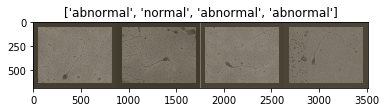

In [33]:
######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print("here")

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/4
----------
train Loss: 0.6235 Acc: 0.7156
val Loss: 0.5521 Acc: 0.7939

Epoch 1/4
----------
train Loss: 0.5923 Acc: 0.7405
val Loss: 0.5002 Acc: 0.7939

Epoch 2/4
----------
train Loss: 0.6100 Acc: 0.7424
val Loss: 0.5743 Acc: 0.7939

Epoch 3/4
----------
train Loss: 0.5607 Acc: 0.7424
val Loss: 0.4858 Acc: 0.7939

Epoch 4/4
----------
train Loss: 0.5592 Acc: 0.7424
val Loss: 0.4944 Acc: 0.7939

Training complete in 0m 45s
Best val Acc: 0.793893


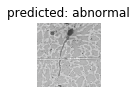

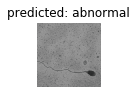

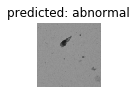

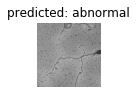

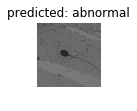

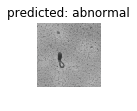

In [10]:

######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)
#
# model_ft = model_ft.to(device)
#
# criterion = nn.CrossEntropyLoss()
#
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

######################################################################
#
# visualize_model(model_ft)


######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

#model_conv = torchvision.models.resnet18(pretrained=True)
#model_conv = torchvision.models.alexnet(pretrained=True)
#model_conv = torchvision.models.vgg(pretrained=True)

#resnet18 = torchvision.models.resnet18(pretrained=True)
#alexnet = torchvision.models.alexnet(pretrained=True)
#vgg16 = torchvision.models.vgg16(pretrained=True)


def arch(model_conv):
    if (model_conv == 'resnet18'):
        model_conv = torchvision.models.resnet18(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad = False

        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = model_conv.fc.in_features
        model_conv.fc = nn.Linear(num_ftrs, 2)
        model_conv = model_conv.to(device)
        criterion = nn.CrossEntropyLoss()

        # Observe that only parameters of final layer are being optimized as
        # opposed to before.
        optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

        return model_conv, criterion, optimizer_conv, exp_lr_scheduler
        # model_conv = train_model(model_conv, criterion, optimizer_conv,
        #                          exp_lr_scheduler, num_epochs=10)

    elif (model_conv == 'alexnet'):
        model_ft = torchvision.models.alexnet(pretrained=True)
            # self.classifier = nn.Sequential(
            #     nn.Dropout(),
            #     nn.Linear(256 * 6 * 6, 4096),
            #     nn.ReLU(inplace=True),
            #     nn.Dropout(),
            #     nn.Linear(4096, 4096),
            #     nn.ReLU(inplace=True),
            #     nn.Linear(4096, num_classes),
            # )
            # 6 is selecting the last layer
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 2, bias=True)
        model_ft = model_ft.to(device)
        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0007, momentum=0.9)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

        return model_ft, criterion, optimizer_ft, exp_lr_scheduler
        # model_ft = train_model(model_ft, criterion, optimizer_ft,
        #                          exp_lr_scheduler, num_epochs=10)

    elif (model_conv == 'vgg16'):
        model_vgg = torchvision.models.vgg16(pretrained=True)
        for param in model_vgg.classifier.parameters():
            param.requires_grad = False

        model_vgg.classifier[6].out_features = 2

        model_vgg = model_vgg.to(device)
        criterion = nn.CrossEntropyLoss()
        lr = 0.01
        optimizer = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return model_vgg, criterion, optimizer, exp_lr_scheduler
        # model_vgg = train_model(model_vgg, criterion, optimizer,
        #                          exp_lr_scheduler, num_epochs=10)



######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_final, criterion, optimizer, exp_lr_scheduler = arch('alexnet')

model_final = train_model(model_final, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=5)


# writer.add_image('images', out, 0)
# writer.add_graph(model_final, inputs)
# writer.close()
######################################################################
#

visualize_model(model_final)

plt.ioff()
plt.show()
